## Imports

In [18]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marileonhardsen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

In [20]:
# This loads the file that you want, might take several seconds (up to a minute)

with open("news_sentiment.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[1040])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{'person': 'Bashar al-Assad',
                    'text': 'President',
                    'wdid': 'Q44329'},
                   {'person': 'Emile Hokayem', 'text': 'in Foreign Policy'},
                   {'person': 'Ahrar al Sham',
                    'text': 'the most important groups',
                    'wdid': 'Q860943'},
                   {'person': 'Vladimir Putin',
                    'text': 'Russian President',
                    'wdid': 'Q7747'},
                   {'person': 'Barack Obama',
                    'text': 'U.S. President',
                    'wdid': 'Q76'},
                   {'person': 'Osama Abu Zeid',
                    'text': 'a senior adviser to the moderate Free Syrian '
                            'Army'},
                   {'person': 'Op-Ed',
                    'text': 'for The Washington Post',
                    'wdid': 'Q2602337'},
                  

In [21]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [22]:
# get only articles from one story, you can change this
articles = ISIS_articles

## Extract introductions, and obtain their sentiment

In [23]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    intro['sentiment'] = analyzer.polarity_scores(intro['text'])['compound']

A Jupyter Widget

In [25]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 100)
for intro in subsample:
    if intro['sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])

---------------
Entity mentionned: Nader
another Hariri supporter
Sentiment: 0.2732
---------------
Entity mentionned: Kuznetshov
Admiral
Sentiment: 0.3182
---------------
Entity mentionned: Matthew Rycroft
opening his remarks after the first resolution failed to be adopted
Sentiment: -0.5106
---------------
Entity mentionned: Staffan de Mistura
the United Nations special envoy to Syria
Sentiment: 0.6705
---------------
Entity mentionned: Gulen
who has built up a network of followers , schools , businesses and charities in Turkey over decades
Sentiment: 0.4939
---------------
Entity mentionned: Khaled al-Obeidi
Defense Minister
Sentiment: 0.128
---------------
Entity mentionned: Muqtada al-Sadr
influential Iraqi Shiite cleric
Sentiment: 0.4404
---------------
Entity mentionned: Richard Gowan
associate director for crisis diplomacy and peace operations at the New York University Center on International Cooperation
Sentiment: -0.1531
---------------
Entity mentionned: Bekir Bozdag
Turkis

## Build a 2-dimensional object containing sentiment per entity, per source

In [26]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['sentiment'])

In [27]:
# An example of how one entity (a city) is described by different sources

print(ent_source_sent['Aleppo'])

{'bbc.co.uk': [0.0516, 0.0, -0.1531, 0.0, 0.0, 0.0, -0.1531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1531, -0.3182, -0.5994, -0.5994, 0.0, 0.0, 0.0, -0.1531, 0.0, 0.0, 0.0, -0.1531, 0.0, 0.0, 0.0], 'cnn.com': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0516, 0.0, 0.0, 0.0, -0.5994, -0.3818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7096, -0.7096, 0.0, 0.0, 0.0, -0.3612, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1779], 'theguardian.com': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7096, 0.0, -0.1531, 0.0], 'middleeasteye.net': [-0.1531, 0.0, 0.0, 0.0, 0.0, -0.1531, -0.4404, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3612, 0.0, 0.0, -0.1531, 0.0, 0.0, -0.1531, 0.0, 0.0, -0.1531, -0.1531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [28]:
# We get rid of entities that don't contain enough data

entities_kept = []

for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 7852  /  25128 in our dataset
We have  22 sources:  ['aa.com.tr', 'wikinews.org', 'rt.com', 'cnn.com', 'theguardian.com', 'reuters.com', 'france24.com', 'allafrica.com', 'aljazeera.com', 'businessinsider.in', 'nytimes.com', 'middleeasteye.net', 'independent.co.uk', 'chinadaily.com.cn', 'washingtonpost.com', 'foxnews.com', 'techcrunch.com', 'latimes.com', 'bbc.co.uk', 'bloomberg.com', 'telegraph.co.uk', 'ap.org']


## We create the array we will use in our sparse model

In [29]:
# Parameters: changing these affects the results you get
Pos_neg_ratio = 2.0
overall_ratio = 0.15
pos_threshold = 0.15
neg_threshold = -0.15

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        N_pos = float(len(np.where(sent_array > pos_threshold)[0]))
        N_neg = float(len(np.where(sent_array < neg_threshold)[0]))
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 19062, 1: 3650, -1: 2669})


## Model source similarity

In [30]:
# Write code that uses this matrix (entities, sources) to compute
# source similarity visible in bias of the way they describe entities

In [31]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A)

In [32]:
from sklearn.covariance import GraphLasso
graph_lasso = GraphLasso(alpha=0.12)
graph_lasso.fit(A_std)
np.mean(graph_lasso.get_precision() > 0)

for (i, j) in zip(*np.where(abs(graph_lasso.get_precision()) > 0)):
    if i > j:
        print(sources[i], sources[j])

reuters.com cnn.com
france24.com cnn.com
france24.com reuters.com
aljazeera.com aa.com.tr
aljazeera.com theguardian.com
aljazeera.com france24.com
nytimes.com reuters.com
middleeasteye.net theguardian.com
middleeasteye.net france24.com
middleeasteye.net aljazeera.com
independent.co.uk theguardian.com
independent.co.uk aljazeera.com
chinadaily.com.cn wikinews.org
chinadaily.com.cn rt.com
washingtonpost.com cnn.com
washingtonpost.com reuters.com
washingtonpost.com nytimes.com
foxnews.com cnn.com
foxnews.com reuters.com
foxnews.com france24.com
foxnews.com independent.co.uk
foxnews.com washingtonpost.com
latimes.com wikinews.org
bbc.co.uk theguardian.com
bbc.co.uk aljazeera.com
bbc.co.uk middleeasteye.net
bloomberg.com cnn.com
bloomberg.com reuters.com
bloomberg.com nytimes.com
bloomberg.com washingtonpost.com
bloomberg.com foxnews.com
telegraph.co.uk cnn.com
telegraph.co.uk reuters.com
telegraph.co.uk france24.com
telegraph.co.uk washingtonpost.com
telegraph.co.uk foxnews.com
telegraph.c

## Workspace

In [33]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [34]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

0.1


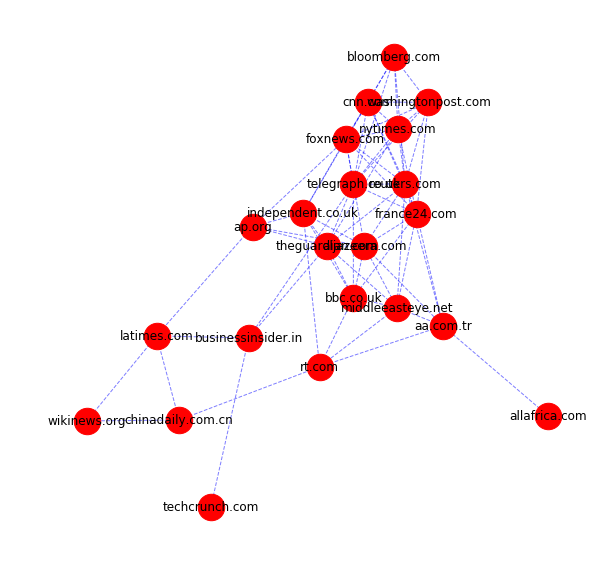

0.11


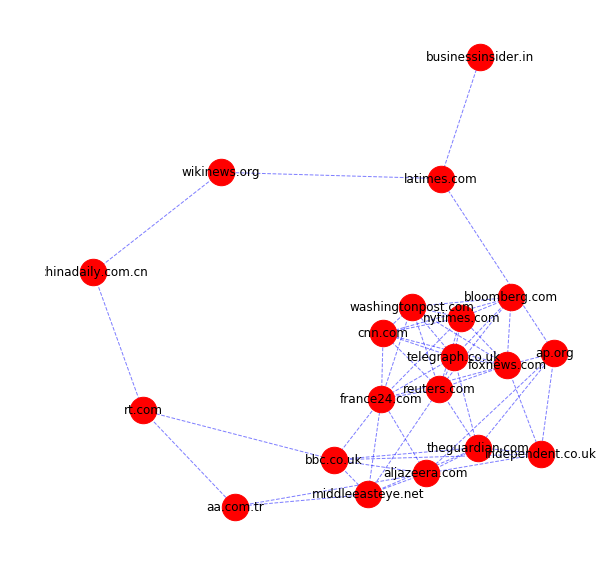

0.12


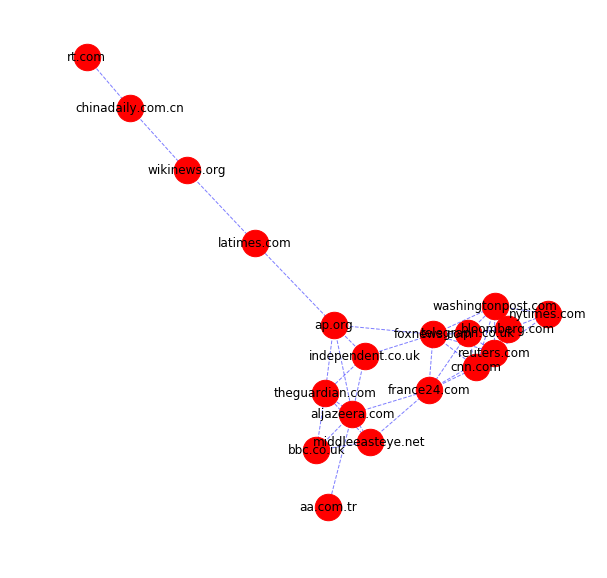

0.13


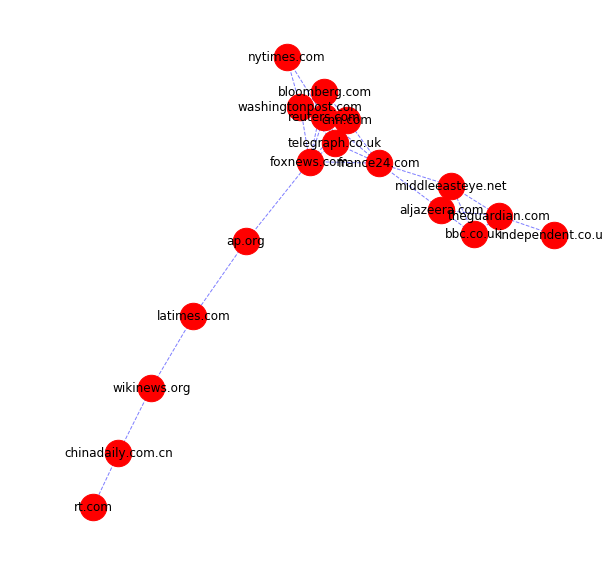

0.14


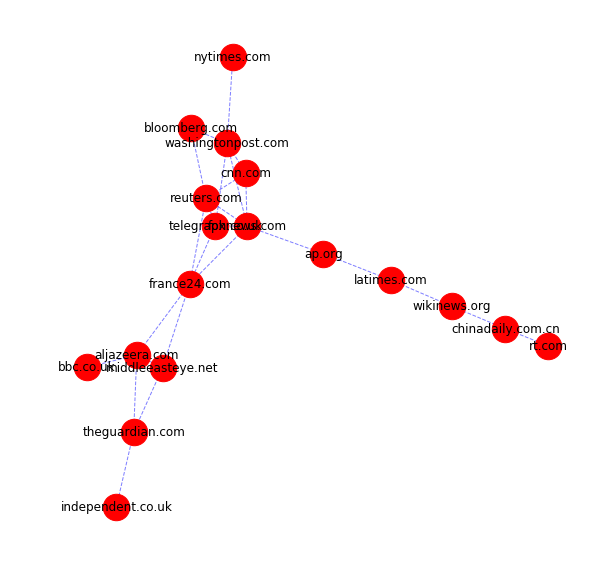

0.15


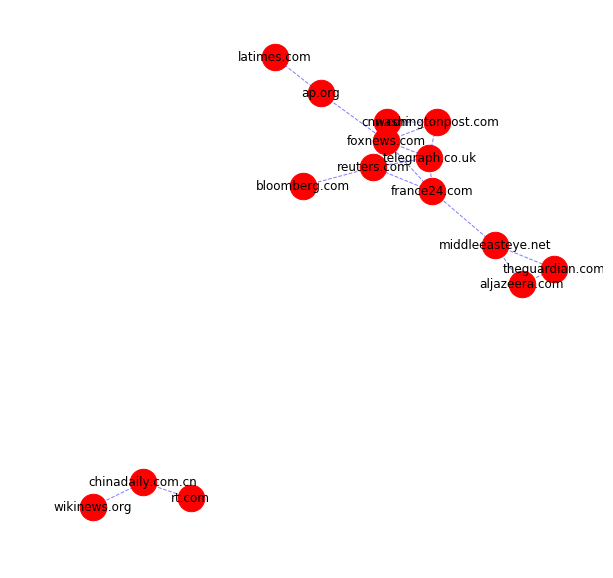

0.16


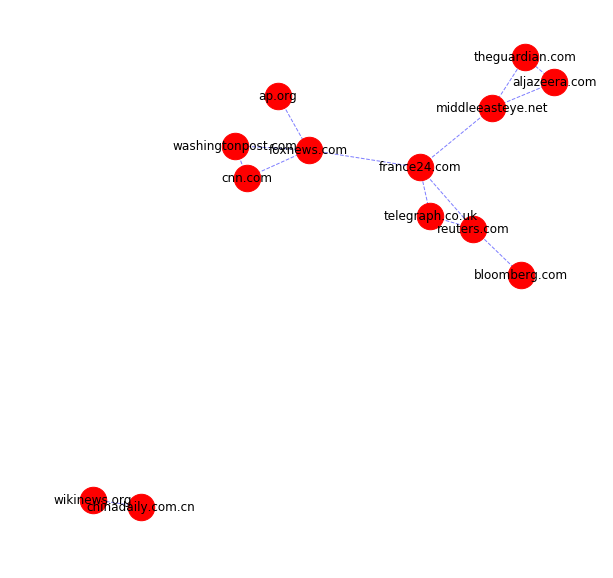

0.17


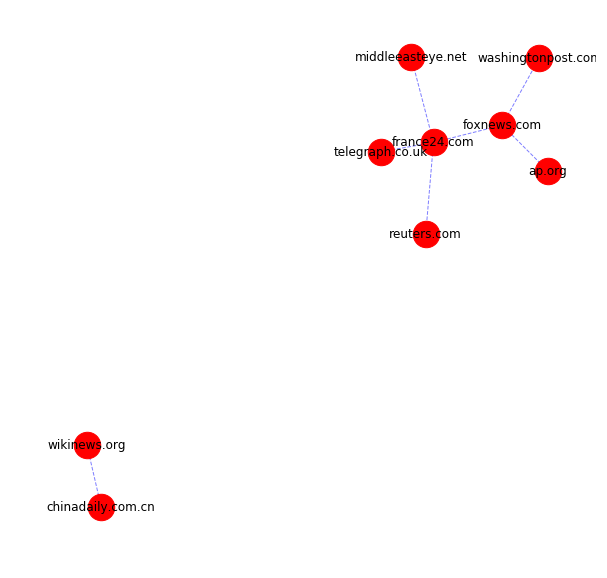

0.18


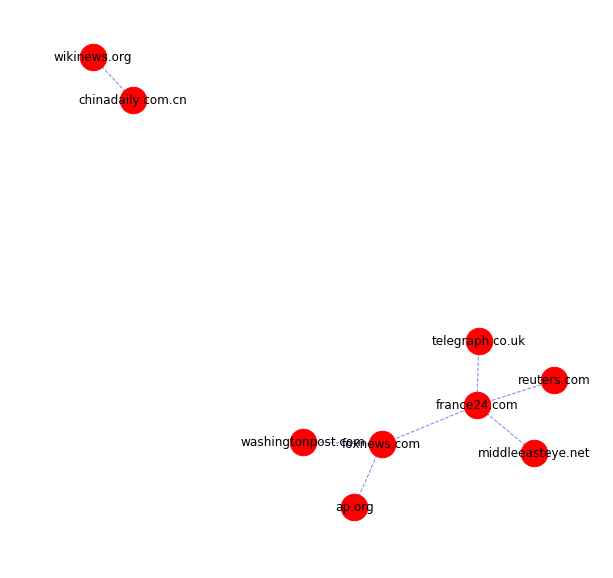

0.19


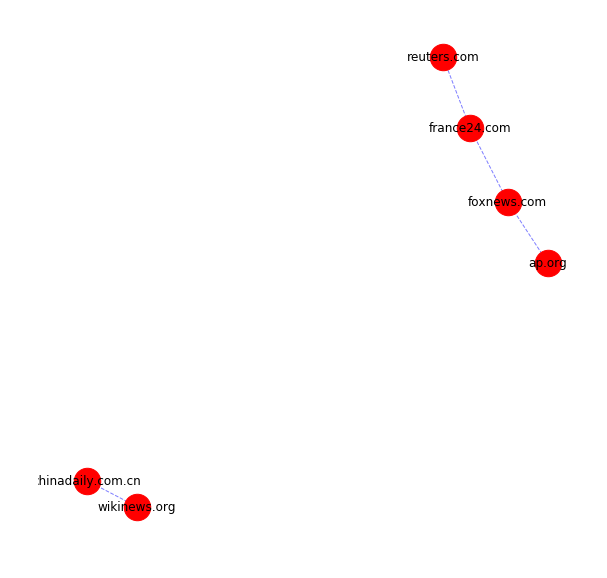

In [35]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    graph_lasso = GraphLasso(alpha=l1_lambda)
    graph_lasso.fit(A_std)
    plot_network(graph_lasso.get_precision(), sources)

In [36]:
from GraphicalLasso import GraphicalLasso as GL
from GramLassoSolver import GramLassoSolver as GramLasso
from sklearn import linear_model
def my_graphical_lasso(data, l1_lambda):
    gl = GL(l1_solver_f=GramLasso)
    S = np.cov(data.T)
    return gl.fit(S, l1_lambda)

## Our Glasso: Lambda sweeping

0.1


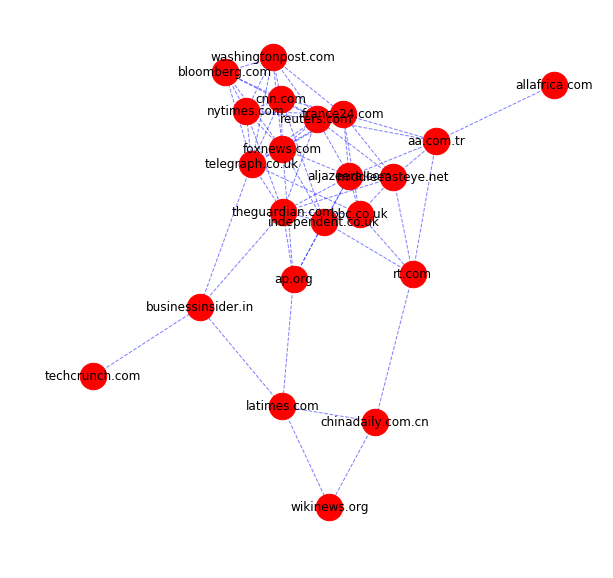

0.11


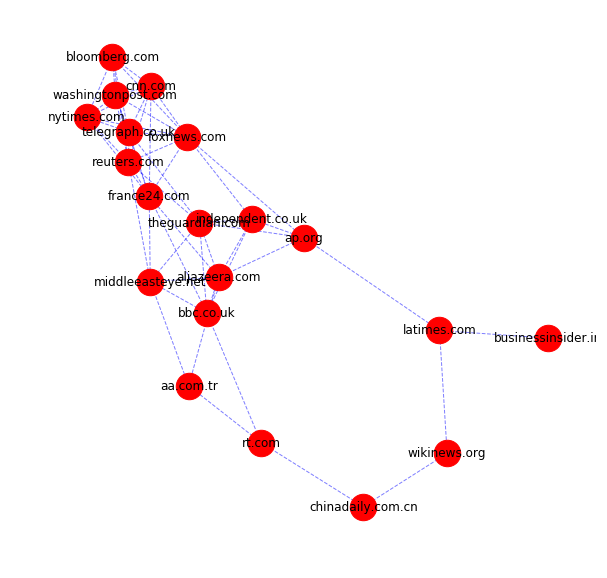

0.12


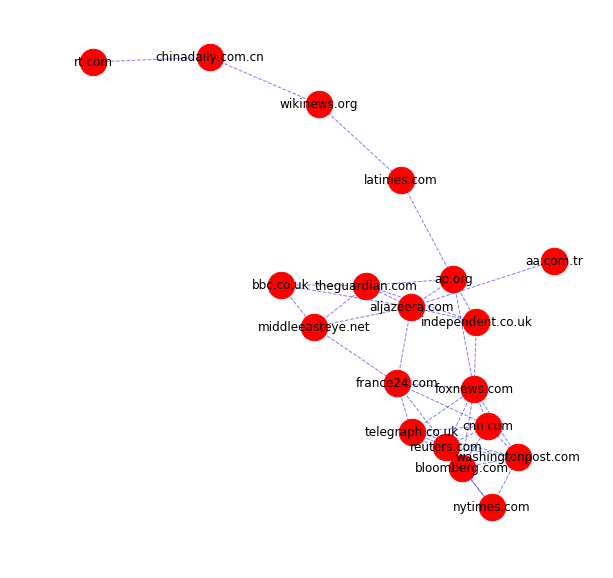

0.13


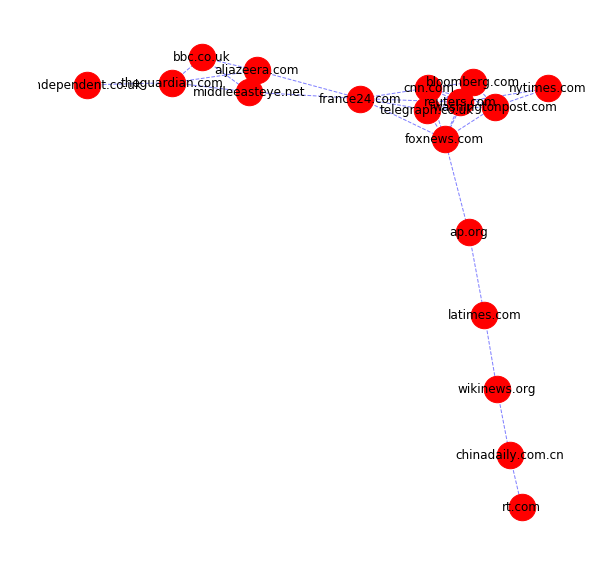

0.14


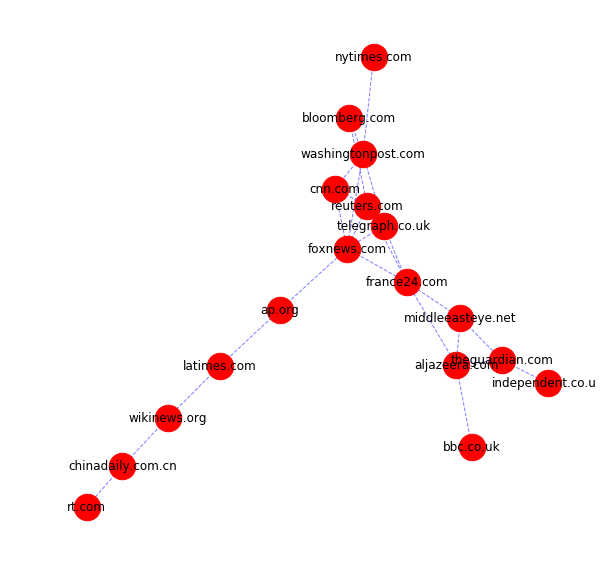

0.15


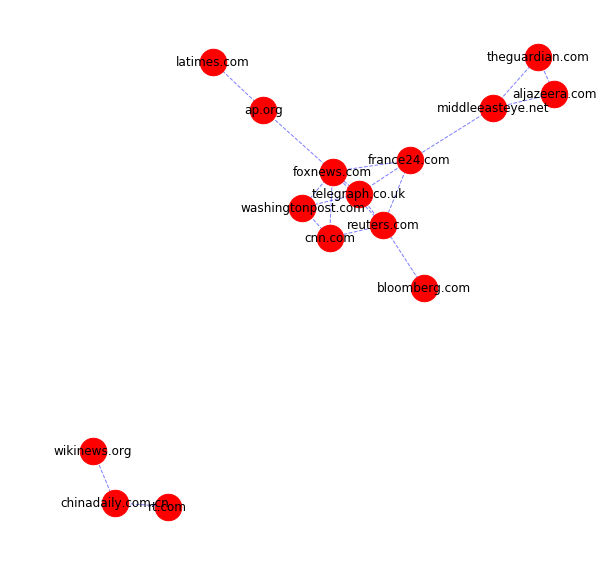

0.16


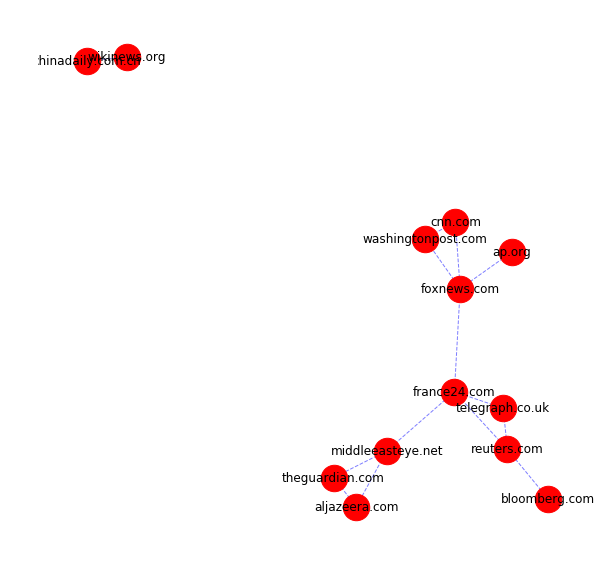

0.17


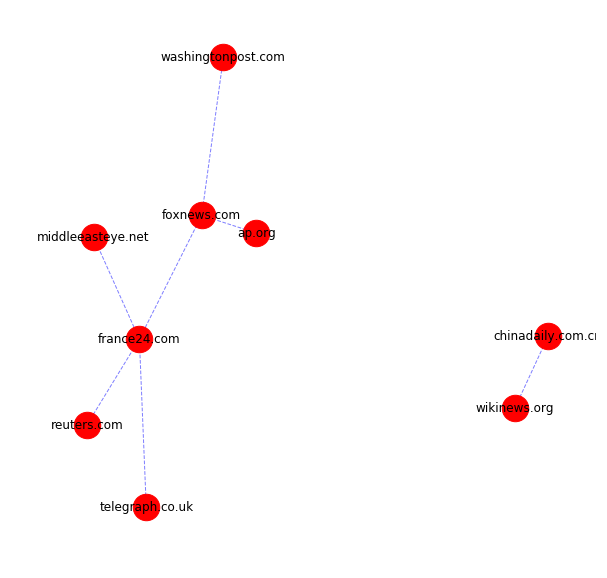

0.18


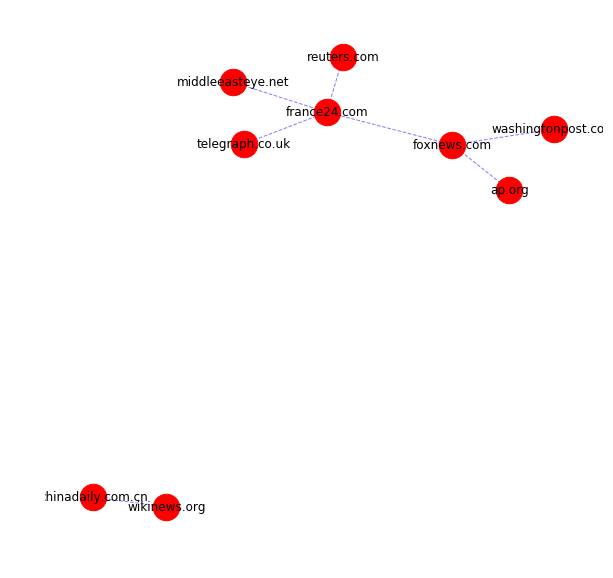

0.19


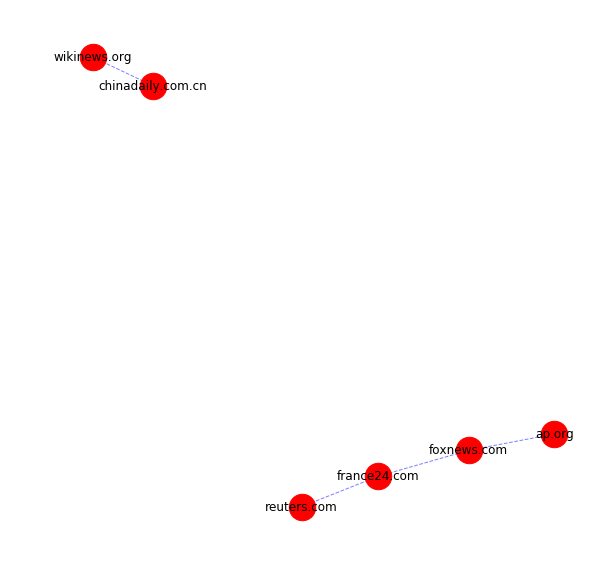

In [37]:
for i in np.arange(0.1,0.2, 0.01):
    l1_lambda = i
    print(l1_lambda)
    plot_network(my_graphical_lasso(A_std, l1_lambda), sources)

## Our Glasso: best by inspection

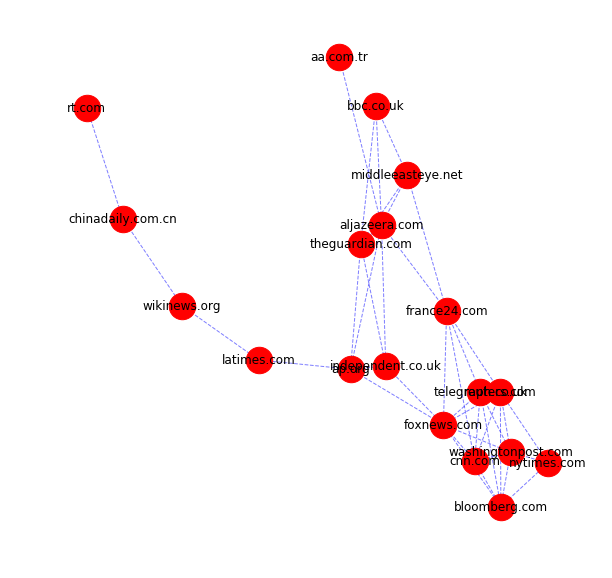

In [38]:
plot_network(my_graphical_lasso(A_std, l1_lambda=0.12), sources)

## Neighborhood method

In [88]:
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso

In [89]:
n_sel = NGraphSelection(Lasso)
g = n_sel.fit(A_std, 0.10, 'AND')

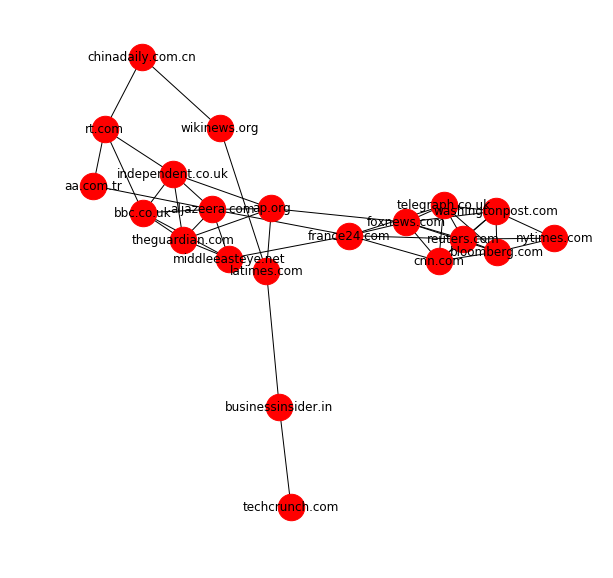

In [90]:
plot_network(g, sources)

## Neighborhood method w/own Lasso implementation (not correct)

In [91]:
from Lasso import Lasso as Lasso1

In [92]:
n_sel = NGraphSelection(Lasso1)
g = n_sel.fit(A_std, 0.10, 'AND')

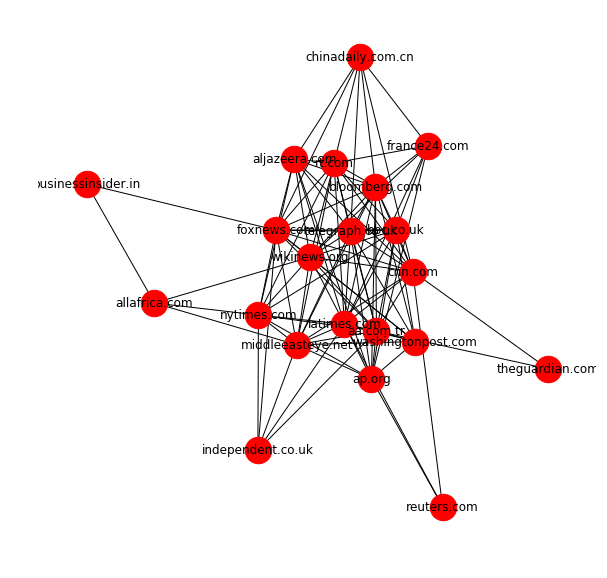

In [93]:
plot_network(g, sources)